In [3]:
import glob
import cv2
import skimage.io as io
import numpy as np
import pandas as pd
import pydicom
import pydicom.data
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.model_selection import train_test_split
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from tensorflow.keras.applications import ResNet152V2

img_rows, img_cols = 224,224

model = ResNet152V2(weights = "imagenet",
                   include_top = False,
                   input_shape =(img_rows,img_cols, 3))
for layer in model.layers:
    layer.trainable=False #katmanları dondur

In [5]:
def layer_adder(bottom_model,num_classes):
    top_model=bottom_model.output
    top_model=GlobalAveragePooling2D()(top_model)
    top_model=Dense(1024,activation='relu')(top_model)
    top_model=Dropout(0.3)(top_model)
    top_model=Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model

num_classes=3#inmeyok,iskemi,kanama
FC_Head=layer_adder(model,num_classes)
model=Model(inputs=model.input,outputs=FC_Head)
print(model.summary())#bu çalışcak

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:

train_data_dir= "C:\\Users\\user\\Desktop\\preprocessDataSet\\train\\"
validation_data_dir=  "C:\\Users\\user\\Desktop\\preprocessDataSet\\val\\"
test_data_dir='C:\\Users\\user\\Desktop\\dataSet\\test\\'

In [8]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=32

train_datagen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical')
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_rows,img_cols),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 5318 images belonging to 3 classes.
Found 996 images belonging to 3 classes.
Found 115 images belonging to 1 classes.


In [ ]:
def ResNet152v2():
    history_all ={}
    epochs=1

    checkpoint=ModelCheckpoint('resnet152-normalönisleme20epoch.h5',
                           monitor='val_loss',
                           mod="min",
                           save_best_only=True,
                           verbose=1)
    """earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1,
                        restore_best_weights=True)"""
    #callbacks=[earlystop,checkpoint]
    callbacks=[checkpoint]
    opt = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
    """sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
    model.compile(optimizer = sgd, 
                loss='categorical_crossentropy',
                metrics=['accuracy'])"""

    history=model.fit(
                train_generator,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator)

    if len(history_all) == 0:
        history_all = {key: [] for key in history.history}
        
    for key in history_all:
        history_all[key].extend(history.history[key])
    return model()

In [24]:
from tensorflow.keras import optimizers
from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping

history_all ={}
epochs=20

checkpoint=ModelCheckpoint('resnet152-normalönisleme20epoch.h5',
                           monitor='val_loss',
                           mod="min",
                           save_best_only=True,
                           verbose=1)
"""earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1,
                        restore_best_weights=True)"""
#callbacks=[earlystop,checkpoint]
callbacks=[checkpoint]
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
"""sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(optimizer = sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])"""

history=model.fit(
             train_generator,
             epochs=epochs,
             callbacks=callbacks,
             validation_data=validation_generator)

if len(history_all) == 0:
    history_all = {key: [] for key in history.history}
    
for key in history_all:
    history_all[key].extend(history.history[key])

Epoch 1/20
167/167 [==============================] - 1542s 9s/step - loss: 0.5229 - accuracy: 0.8016 - val_loss: 0.5247 - val_accuracy: 0.8112

Epoch 00001: val_loss improved from inf to 0.52470, saving model to resnet152-normalönisleme20epoch.h5


C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
167/167 [==============================] - 1631s 10s/step - loss: 0.5072 - accuracy: 0.7979 - val_loss: 0.6278 - val_accuracy: 0.7861

Epoch 00002: val_loss did not improve from 0.52470
Epoch 3/20
167/167 [==============================] - 1676s 10s/step - loss: 0.4811 - accuracy: 0.8127 - val_loss: 0.5928 - val_accuracy: 0.7992

Epoch 00003: val_loss did not improve from 0.52470
Epoch 4/20
167/167 [==============================] - 2193s 13s/step - loss: 0.4606 - accuracy: 0.8159 - val_loss: 0.4892 - val_accuracy: 0.8333

Epoch 00004: val_loss improved from 0.52470 to 0.48924, saving model to resnet152-normalönisleme20epoch.h5
Epoch 5/20
167/167 [==============================] - 2057s 12s/step - loss: 0.4559 - accuracy: 0.8244 - val_loss: 0.4982 - val_accuracy: 0.8163

Epoch 00005: val_loss did not improve from 0.48924
Epoch 6/20
167/167 [==============================] - 2015s 12s/step - loss: 0.4342 - accuracy: 0.8317 - val_loss: 0.5560 - val_accuracy: 0.8173

Epoch 0000

KeyboardInterrupt: 

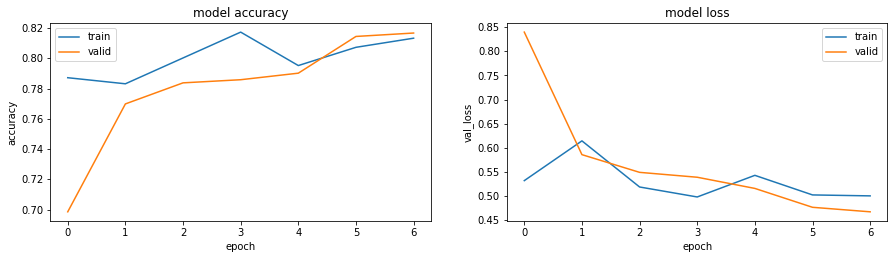

In [10]:
plt.figure(1, figsize = (15,8))
   
plt.subplot(221)  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['val_loss'])  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('val_loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [11]:
from keras.models import load_model
classifier=load_model('resnet152-normalönisleme.h5')

In [12]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)
print(predicted_class_indices)

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


4/4 [==============================] - 30s 6s/step
[0 0 0 0 1 2 2 0 0 0 0 0 0 2 0 0 0 0 0 1 1 2 0 2 0 0 0 1 0 0 0 2 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 2 2 1 0 0 1 0 0 0 0 0 2 2 0 0 0 0 0 0 2 0 1 0 0 0 0
 0 0 0 0 1 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 1 2 0 0 0 0 0 0
 0 0 0 0]


In [30]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=104,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

104/104 [==============================] - 27s 192ms/step
[0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1]


In [21]:
test_generator.class_indices
test_generator.reset()

In [31]:
test_generator.class_indices, test_generator.samples, test_generator.labels

({'TEST1': 0},
 115,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]))

In [12]:
test_generator.filenames[0:10]

['INMEYOK\\10090.png',
 'INMEYOK\\10107.png',
 'INMEYOK\\10122.png',
 'INMEYOK\\10124.png',
 'INMEYOK\\10129.png',
 'INMEYOK\\10136.png',
 'INMEYOK\\10176.png',
 'INMEYOK\\10282.png',
 'INMEYOK\\10325.png',
 'INMEYOK\\10359.png']

In [41]:
x,y = next(test_generator)

In [24]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==test_generator.classes)/10000

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.0031

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes,y_pred)

array([[  9, 106],
       [  0,   0]], dtype=int64)

In [15]:
results_df1 = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df1.sort_values(by='id', inplace = True)

results_df1.to_csv("ResneV2test710epoch.csv", index=False)
results_df1.head()

,id,label
0,TEST1\10017.png,0
1,TEST1\10090.png,0
2,TEST1\10107.png,0
3,TEST1\10122.png,0
4,TEST1\10124.png,1


In [16]:
predicted_class_indices

array([0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2,
       0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int64)

In [17]:
df1=pd.read_csv('truthFile.csv')
df1

,Id,label
0,TEST\10090.png,0
1,TEST\10107.png,0
2,TEST\10155.png,2
3,TEST\10117.png,1
4,TEST\10188.png,1
...,...,...
110,TEST\16182.png,1
111,TEST\15735.png,0
112,TEST\16361.png,0
113,TEST\16557.png,0


In [18]:
df=pd.read_csv('ResneV2test710epoch.csv')
df

,id,label
0,TEST1\10017.png,0
1,TEST1\10090.png,0
2,TEST1\10107.png,0
3,TEST1\10122.png,0
4,TEST1\10124.png,1
...,...,...
110,TEST1\16557.png,0
111,TEST1\16629.png,0
112,TEST1\16744.png,0
113,TEST1\16860.png,0


In [19]:
tahmin=df['label']
tahmin

0      0
1      0
2      0
3      0
4      1
      ..
110    0
111    0
112    0
113    0
114    0
Name: label, Length: 115, dtype: int64

In [20]:
orijinal=df1['label']
orijinal

0      0
1      0
2      2
3      1
4      1
      ..
110    1
111    0
112    0
113    0
114    0
Name: label, Length: 115, dtype: int64

In [21]:
class_names=["0","1","2"]

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(orijinal, predicted_class_indices, target_names=class_names))

print(confusion_matrix(orijinal, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.51      0.70      0.59        64
           1       0.17      0.08      0.11        26
           2       0.07      0.04      0.05        25

    accuracy                           0.42       115
   macro avg       0.25      0.27      0.25       115
weighted avg       0.34      0.42      0.36       115

[[45  9 10]
 [20  2  4]
 [23  1  1]]
